In [7]:
import datatree as xrtree
import xarray as xr
import zarr

In [8]:
core_profiles = xr.open_dataset(
    "data/core_profiles.h5",
    engine="h5netcdf",
    group="core_profiles",
    phony_dims="access",
)

ValueError: unrecognized engine h5netcdf must be one of: ['store', 'zarr']

In [5]:
core_profiles

NameError: name 'core_profiles' is not defined

In [6]:
core_profiles = (
    core_profiles.drop_dims("phony_dim_1")
    .swap_dims(
        {
            "phony_dim_0": "time",
            "phony_dim_2": "rho_tor_norm",
            "phony_dim_3": "ion",
        }
    )
    .set_coords(
        [
            "profiles_1d[]&grid&rho_tor_norm",
            "profiles_1d[]&ion[]&label",
            "time",
        ]
    )
    .rename_vars(
        {
            "profiles_1d[]&grid&rho_tor_norm": "rho_tor_norm",
            "profiles_1d[]&ion[]&label": "ion",
            "time": "time_base",
        }
    )
)

NameError: name 'core_profiles' is not defined

In [5]:
core_profiles

<xarray.Dataset> Size: 29kB
Dimensions:                                           (time: 1,
                                                       rho_tor_norm: 200, ion: 2)
Coordinates:
    rho_tor_norm                                      (time, rho_tor_norm) float64 2kB ...
    ion                                               (time, ion) <U3 24B ...
  * time_base                                         (time) float64 8B 0.3003
Dimensions without coordinates: time
Data variables: (12/30)
    code&commit                                       <U7 28B ...
    code&name                                         <U19 76B ...
    code&repository                                   <U7 28B ...
    code&version                                      <U7 28B ...
    global_quantities&energy_diamagnetic              (time) float64 8B ...
    global_quantities&ip                              (time) float64 8B ...
    ...                                                ...
    profiles_1d[]&ion[]&pressure_thermal              (time, ion, rho_tor_norm) float64 3kB ...
    profiles_1d[]&ion[]&temperature                   (time, ion, rho_tor_norm) float64 3kB ...
    profiles_1d[]&ion[]&z_ion                         (time, ion) float64 16B ...
    profiles_1d[]&q                                   (time, rho_tor_norm) float64 2kB ...
    profiles_1d[]&t_i_average                         (time, rho_tor_norm) float64 2kB ...
    profiles_1d[]&zeff                                (time, rho_tor_norm) float64 2kB ...

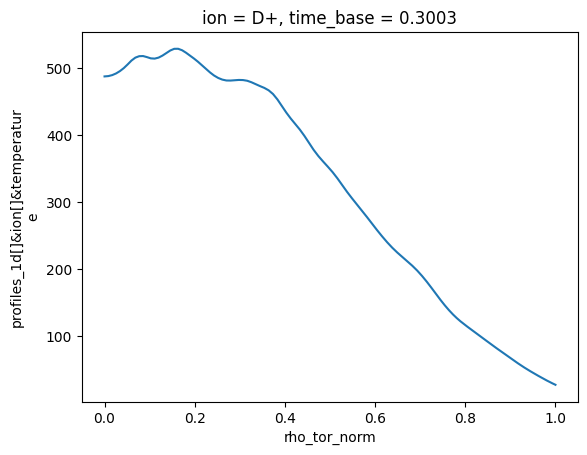

In [7]:
core_profiles["profiles_1d[]&ion[]&temperature"].isel(time=0, ion=0).plot()

In [7]:
core_profiles.to_zarr('data/core_profiles.zarr')

In [8]:
xr.open_zarr("data/core_profiles.zarr")

<xarray.Dataset> Size: 29kB
Dimensions:                                           (time_base: 1, ion: 2,
                                                       rho_tor_norm: 200)
Coordinates:
    ion                                               (time_base, ion) <U3 24B dask.array<chunksize=(1, 2), meta=np.ndarray>
    rho_tor_norm                                      (time_base, rho_tor_norm) float64 2kB dask.array<chunksize=(1, 200), meta=np.ndarray>
    time                                              (time_base) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: time_base
Data variables: (12/30)
    code&commit                                       <U7 28B ...
    code&name                                         <U19 76B ...
    code&repository                                   <U7 28B ...
    code&version                                      <U7 28B ...
    global_quantities&energy_diamagnetic              (time_base) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    global_quantities&ip                              (time_base) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                                ...
    profiles_1d[]&ion[]&pressure_thermal              (time_base, ion, rho_tor_norm) float64 3kB dask.array<chunksize=(1, 2, 200), meta=np.ndarray>
    profiles_1d[]&ion[]&temperature                   (time_base, ion, rho_tor_norm) float64 3kB dask.array<chunksize=(1, 2, 200), meta=np.ndarray>
    profiles_1d[]&ion[]&z_ion                         (time_base, ion) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    profiles_1d[]&q                                   (time_base, rho_tor_norm) float64 2kB dask.array<chunksize=(1, 200), meta=np.ndarray>
    profiles_1d[]&t_i_average                         (time_base, rho_tor_norm) float64 2kB dask.array<chunksize=(1, 200), meta=np.ndarray>
    profiles_1d[]&zeff                                (time_base, rho_tor_norm) float64 2kB dask.array<chunksize=(1, 200), meta=np.ndarray>

In [9]:
with zarr.open("data/core_profiles.zarr", mode="w") as root:
    root.create_dataset("time", data=core_profiles.time.values)
    root.create_dataset("rho_tor_norm", data=core_profiles.rho_tor_norm.values)
    root.create_dataset(
        "electron_temperature",
        data=core_profiles["profiles_1d[]&electrons&temperature"].values,
    )
    root["time"].attrs["_ARRAY_DIMENSIONS"] = ["time"]
    root["rho_tor_norm"].attrs["_ARRAY_DIMENSIONS"] = ["time", "rho_tor_norm"]
    root["electron_temperature"].attrs["_ARRAY_DIMENSIONS"] = ["time", "rho_tor_norm"]
    root.create_group("ions")
    zarr.consolidate_metadata("data/core_profiles.zarr")